In [ ]:
import k3d
import k3d.platonic
import numpy as np
from IPython.display import Image
from IPython.utils.capture import capture_output
from matplotlib import pyplot as plt

# Cluster Reconstruction

As outlined in </TODO>, the MicroMeGaS anode is highly segmented to give good position resolution measurements of the charge clusters produced by ionisation. In order to reconstruct the track trajectories in 3D, it is necessary to determine the initial height of the charge cluster. Given that the MicroMeGaS waveforms are energy-time signals, the height coordinate can be derived from the drift time, given by the locus of the peak in the measured waveform, and the drift velocity (see {ref}`gas-simulation`).
    
## Central Region
Within the central "pads" region, the anode position of a waveform is uniquely determined by the channel from which it was measured. 
    
:::{admonition} To Do
Generate a figure that demonstrates this visually.    
:::
 

## Side Region
Meanwhile, for the multiplexing side regions, only _one_ coordinate is uniquely defined: the column for the _chains_, and the row for the _strips_. In order to localise a waveform in these regions, _another_ waveform must be recorded in the complementary family (strip-chain or chain-strip) of channels such that _both_ coordinates are uniquely determined.
    
The set of valid positions {math}`P` defined for the side regions is naively given by the Cartesian product of the strips {math}`S` and chains {math}`C`, i.e.

:::{math}
:label: set-of-strip-chain-positions
    
P = S \times C\,.
:::

Among these ordered pairs, only a small subset {math}`P_\text{valid}` provides a reasonable interpretation of the observed ion path in the detector. In order to identify this subset, an additional discriminator is required. 

For tracks with a significant inclination to the drift plane, we can use the drift _time_  to order strip-chain pairings by their vertical separation. In the extreme case of a track that lies along the drift axis, the drift time is an exact proxy for the position of the charge distribution along the track (see {numref}`strip-chain-procedure-inclined`). It follows that for some deviation from this ideal case, taking the strip-chain pairs with the smallest time difference will yield a reasonable set of charge clusters.

:::{admonition} To Do
   
Do a better job of explaining how the mechanism of charge formation implies a minimum resolution.
:::
    

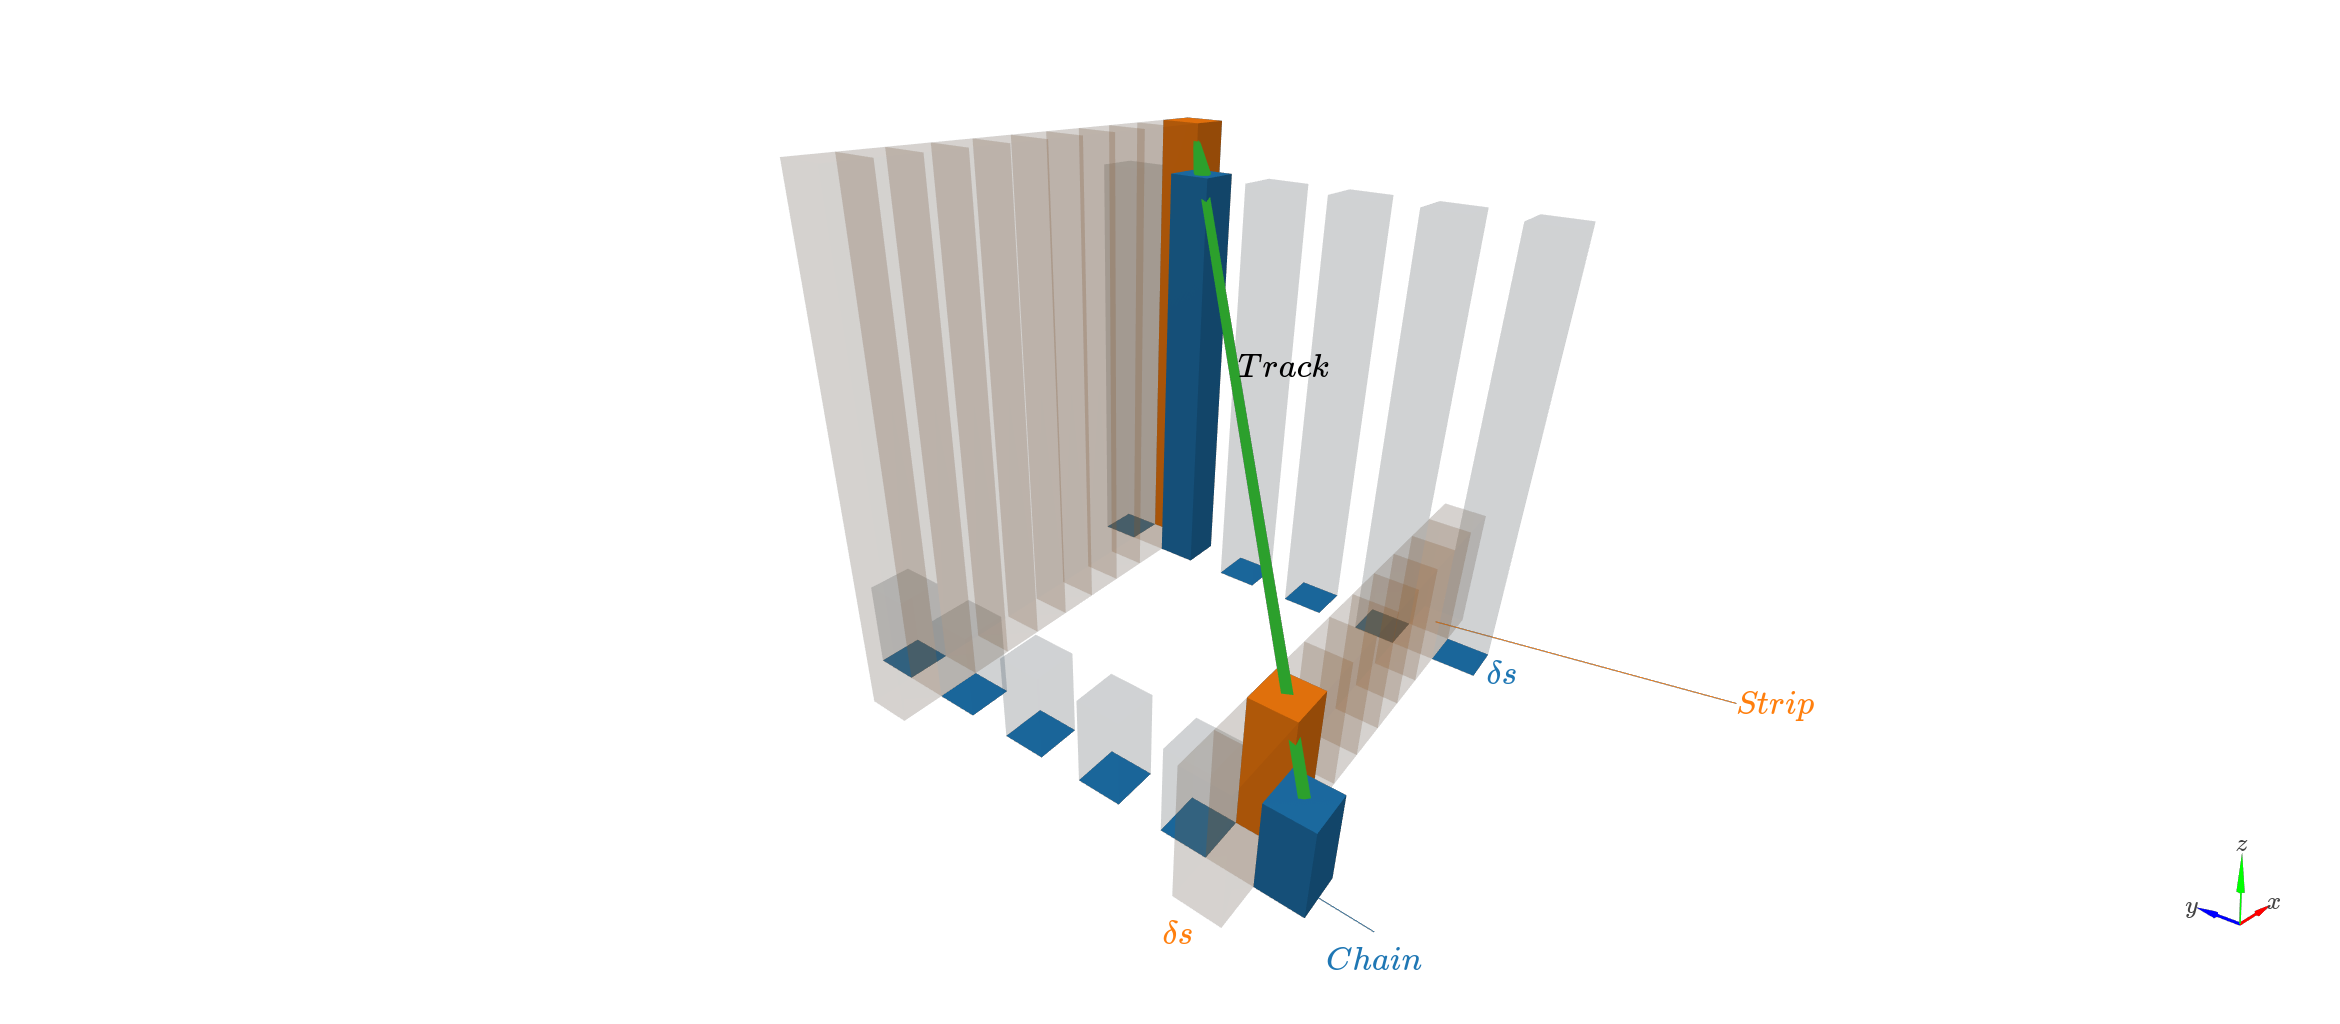

In [172]:
def hex_to_int(color):
    return int(color.replace("#", "0x"), base=16)


colors = [hex_to_int(c) for c in plt.rcParams["axes.prop_cycle"].by_key()["color"]]

# Track parameters
track_rel_dest_inclined = np.array(
    [9, 9, 9],
).astype(np.float32)
track_rel_dest_flat = np.array(
    [9, 9, 0],
).astype(np.float32)
track_origin = np.array([0, 0, 2]).astype(np.float32)

label_box = False
mode = "dynamic"

regions = []
for track_rel_dest in (track_rel_dest_inclined, track_rel_dest_flat):
    track_normal = track_rel_dest / np.linalg.norm(track_rel_dest)

    figure = k3d.plot(camera_auto_fit=False, grid_auto_fit=False, grid_visible=False)

    vertex_square, index_square = k3d.helpers.quad(1, 1)
    vertex_square = vertex_square.reshape(-1, 3)
    dz_dx = dz_dy = track_normal[2] / track_normal[1]

    # Chains
    for j in range(6):
        for dx, k in [(0.0, 0), (8.0, 4)]:
            # Anode
            figure += k3d.mesh(
                (vertex_square + np.array([dx, j * 2, 0], dtype=np.float32)),
                index_square,
                color=colors[0],
            )

            # Volume
            height = track_origin[2] + dz_dx * dx
            mesh = k3d.platonic.Cube(origin=(dx, j * 2, 0.5), size=0.5).mesh
            mesh.transform.scaling = (1, 1, height)
            mesh.opacity = 1 if j == k else 0.1
            mesh.color = colors[0]
            figure += mesh

    # Strips
    for j in range(-1, 10):
        for dy, k in [(1.0, 1), (9.0, 9)]:
            figure += k3d.mesh(
                (track_rel_dest + np.array([j - 1, dy, 0], dtype=np.float32)),
                index_square,
                color=colors[1],
            )

            height = track_origin[2] + dz_dy * dy
            mesh = k3d.platonic.Cube(origin=(j, dy, 0.5), size=0.5).mesh
            mesh.transform.scaling = (1, 1, height)
            mesh.opacity = 1 if j == k else 0.1
            mesh.color = colors[1]
            figure += mesh

    figure += k3d.vectors(
        track_origin,
        track_rel_dest,
        labels=["Track"],
        head_size=10,
        line_width=0.2,
        color=colors[2],
    )
    figure += k3d.label(
        "Strip", position=(9, 1, 0), label_box=False, mode="dynamic", color=colors[1]
    )
    figure += k3d.label(
        "Chain", position=(0, 0, 0), label_box=False, mode="dynamic", color=colors[0]
    )
    figure += k3d.text(
        "\\delta s",
        label_box=False,
        color=colors[0],
        position=(8, -1, 0),
        reference_point="cc",
    )
    figure += k3d.text(
        "\\delta s",
        label_box=False,
        color=colors[1],
        position=(-2, 1, 0),
        reference_point="cc",
    )
    figure.camera = [
        -9.822822213715366,
        -4.194570505957099,
        12.96418251949558,
        4.370696968325828,
        6.003370264768876,
        3.3814781082597327,
        0.3329404227065243,
        0.2757029488135719,
        0.9017419580697668,
    ]

    regions.append(figure)

# Provide image fallback
with capture_output() as c:
    display(regions[0], Image("image/strip-chain-correlation-inclined.png"))

display(c.outputs[0].data | c.outputs[1].data, raw=True)

Meanwhile, the charge distributions formed along a track have a non-zero width and relative position to the average track direction; the electrons liberated by scattering of the incident ion arrest over a finite distance within the gas. There is therefore a _minimum_ time-separation below which a "reasonable set" of pair can not be discriminated from those which arise from random correlations. In the extreme case, a track that lies exactly within the drift plane will yield strip-chain pairs that are entirely separated in time by the uncertainty on the cluster position, and this method cannot be used (see {numref}`strip-chain-procedure-planar`).

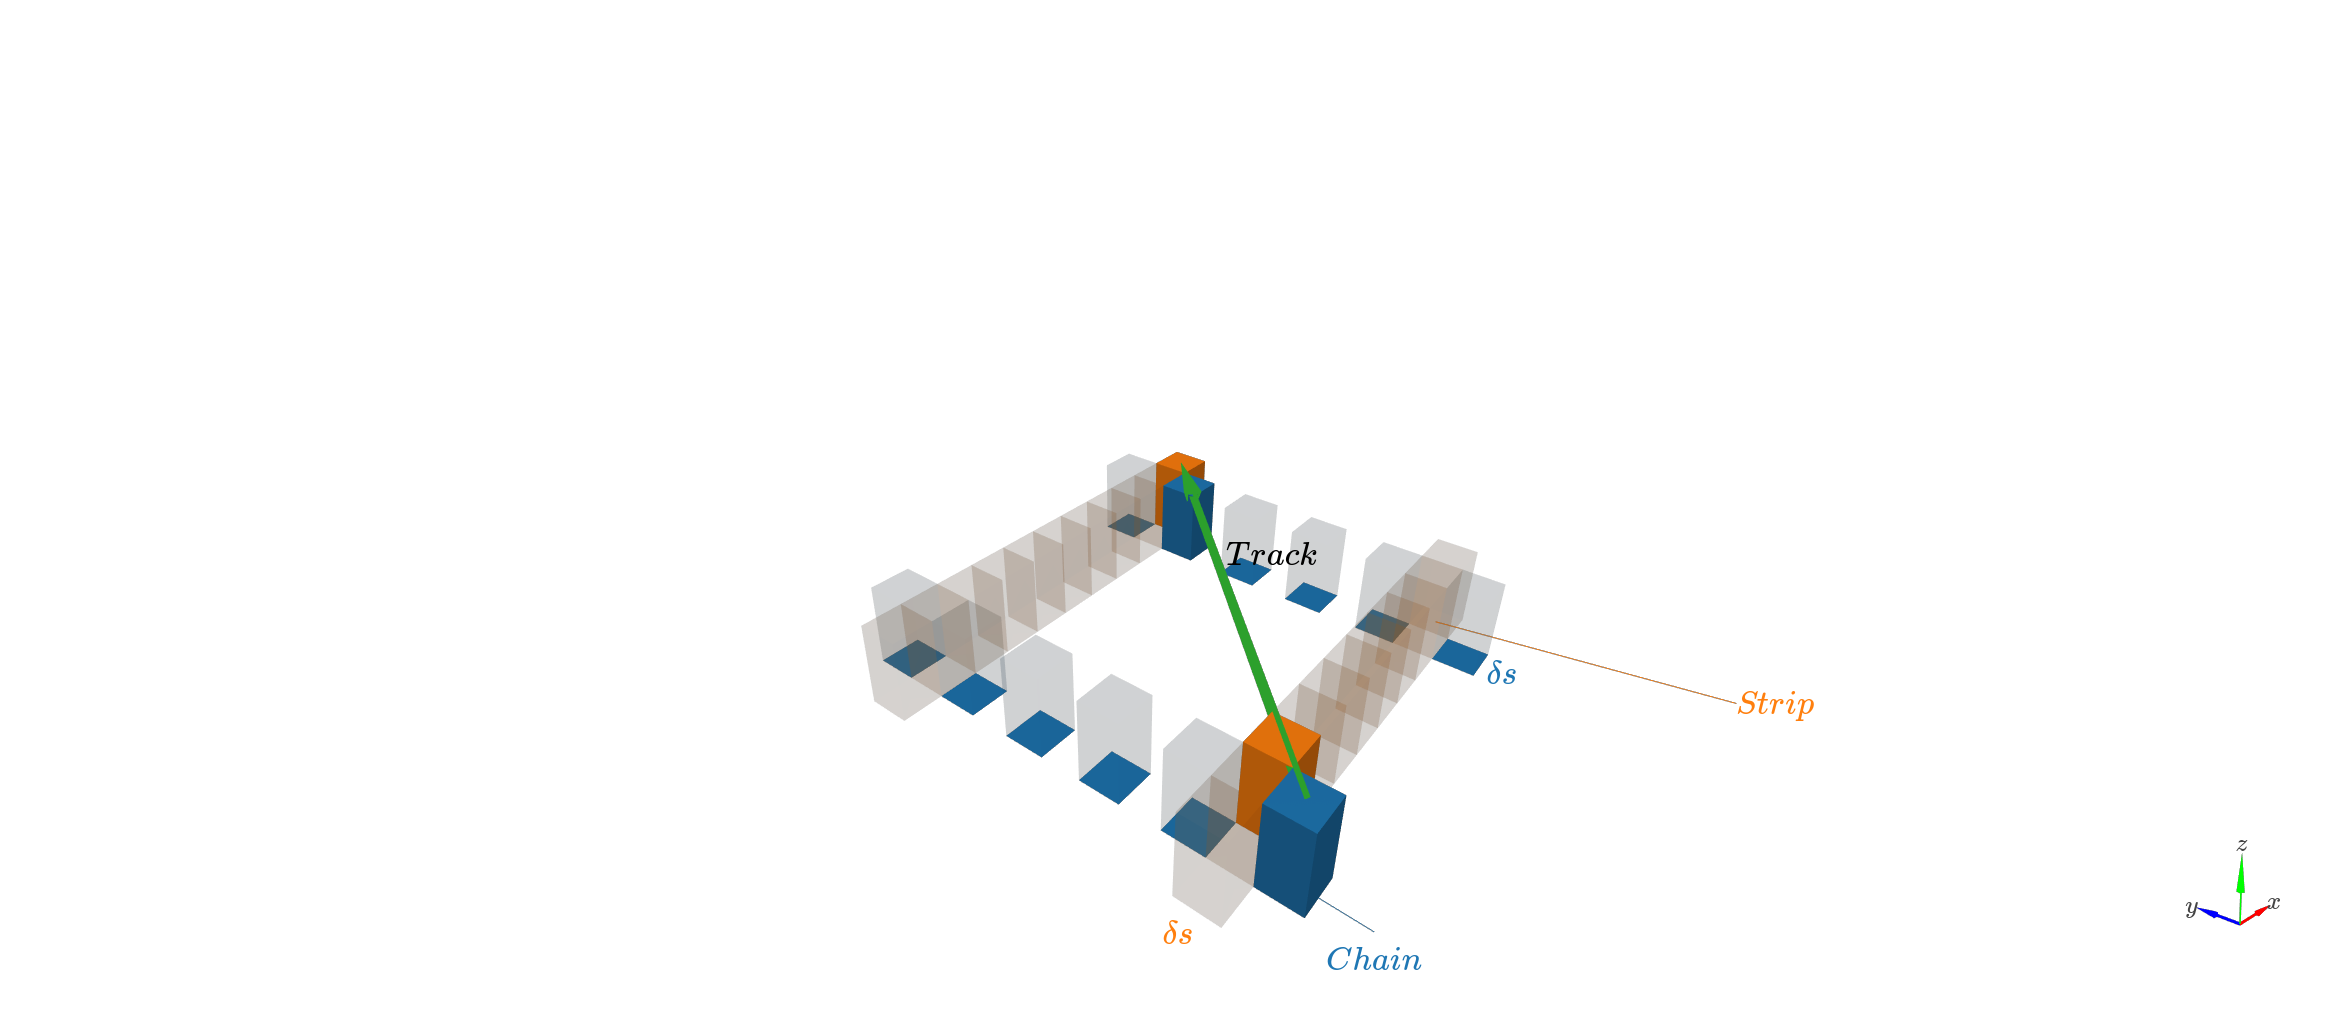

In [171]:
# Provide image fallback
with capture_output() as c:
    display(regions[1], Image("image/strip-chain-correlation-planar.png"))

display(c.outputs[0].data | c.outputs[1].data, raw=True)

To discern the range over which time-separation holds as a valuable reconstruction method, consider a track with the gradient {math}`\dv{z}{s}` at 45° to the element stacking axis, where _element_ refers to a strip or chain.
Any two elements (strip-strip or chain-chain) are separated by a fixed spacing {math}`\delta s`. The separation between an adjacent hit on a strip-chain pair is therefore {math}`\sqrt{2\left(\delta s\right)^2}`. The change in height between the members of the pair consequently given by {math}`\delta z = \dv{z}{s}\cdot\sqrt{2}\delta s`. For some intrinsic width $\sigma$ of the charge distribution about the track, it follows that the resolving limit is
:::{math}
:label: time-resolving-limit

\dv{z}{s} \geq \frac{\sigma}{\sqrt{2}\delta s}
:::